## Using Machine Learning to Predict Breast Cancer

This project utilizes the __[Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)__ for predictive analysis in breast cancer. Key tools used for this project include: Jupyter Notebook, Python - numpy, pandas, matplotlib, plotly, seaborn and scikit-learn


### __[Summary on the Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)__

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link] 

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes. 

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34]. 

This database is also available through the UW CS ftp server: 
ftp ftp.cs.wisc.edu 
cd math-prog/cpo-dataset/machine-learn/WDBC/


Attribute Information:

1) ID number 
2) Diagnosis (M = malignant, B = benign) 
3-32) 

Ten real-valued features are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)


### Loading Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import mpld3 as mpl
import itertools
from itertools import chain
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore") 

### Data Loading

In [15]:
data = pd.read_csv("Project_Data/WISC_breast_cancer_data.csv", header = 0)#Loading CSV file

### Data Cleaning and Inspection

In [16]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

All columns have the same number of features but for "Unnamed: 32". In the next check I will check for and validate missingness

In [18]:
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'steelblue',
        line=dict(color='black',width=1.5)))

layout = dict(title =  "Checking Data Missingness", plot_bgcolor = "white")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

As we can see from the plot above, all features are complete but for 'Unnamed: 32' which has none and therefore will be dropped.

In [19]:
#Dropping 'Unnamed: 32' with no values
data.drop('Unnamed: 32', axis=1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [21]:
#Validating drop
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'steelblue',
        line=dict(color='black',width=1.5)))

layout = dict(title =  "Checking Data Missingness", plot_bgcolor = "white")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

Feature 'Unnamed: 32' has been dropped from the dataset


As we can see from the dataset, we have 2 features that represente attribute Information: 1) ID number and 2) Diagnosis (M = malignant, B = benign) 
 

The resta are real-valued features (10) that are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

In [22]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [23]:
data.diagnosis.unique()

array(['M', 'B'], dtype=object)

### Checking diagnosis distribution

In [24]:
# 2 datasets
# Reassign target
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
Malignant = data[(data['diagnosis'] != 0)]
Benign = data[(data['diagnosis'] == 0)]

trace = go.Bar( x = ['Malignant', 'Benign'], y = (len(Malignant), len(Benign)),opacity = 0.5, marker=dict(color = 'steelblue',
        line=dict(color='gray',width=0.5)))

layout = dict(title =  'Diagnosis Distribution', plot_bgcolor = "white")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### Investigating computed cell nucleus features per diagnosis type: 

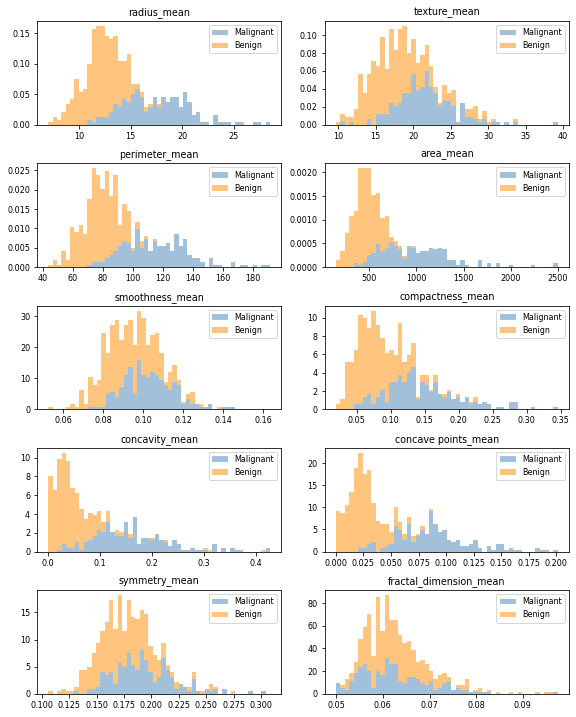

In [25]:
features_mean=list(data.columns[2:12])
# split dataframe into two based on diagnosis
#dfM=df[df['diagnosis'] ==1]
#dfB=df[df['diagnosis'] ==0]

#Stack the data
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(data[features_mean[idx]]) - min(data[features_mean[idx]]))/50
    ax.hist([Malignant[features_mean[idx]],Benign[features_mean[idx]]], bins=np.arange(min(data[features_mean[idx]]), max(data[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True, density=True, label=['Malignant','Benign'],color=['steelblue','darkorange'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

Overall, we consistently see higher mean values per feature in malignant cells. We can leverage this for our classifications

### Checking Feature Correlation

Text(0.5, 1.0, 'Correlation Plot')

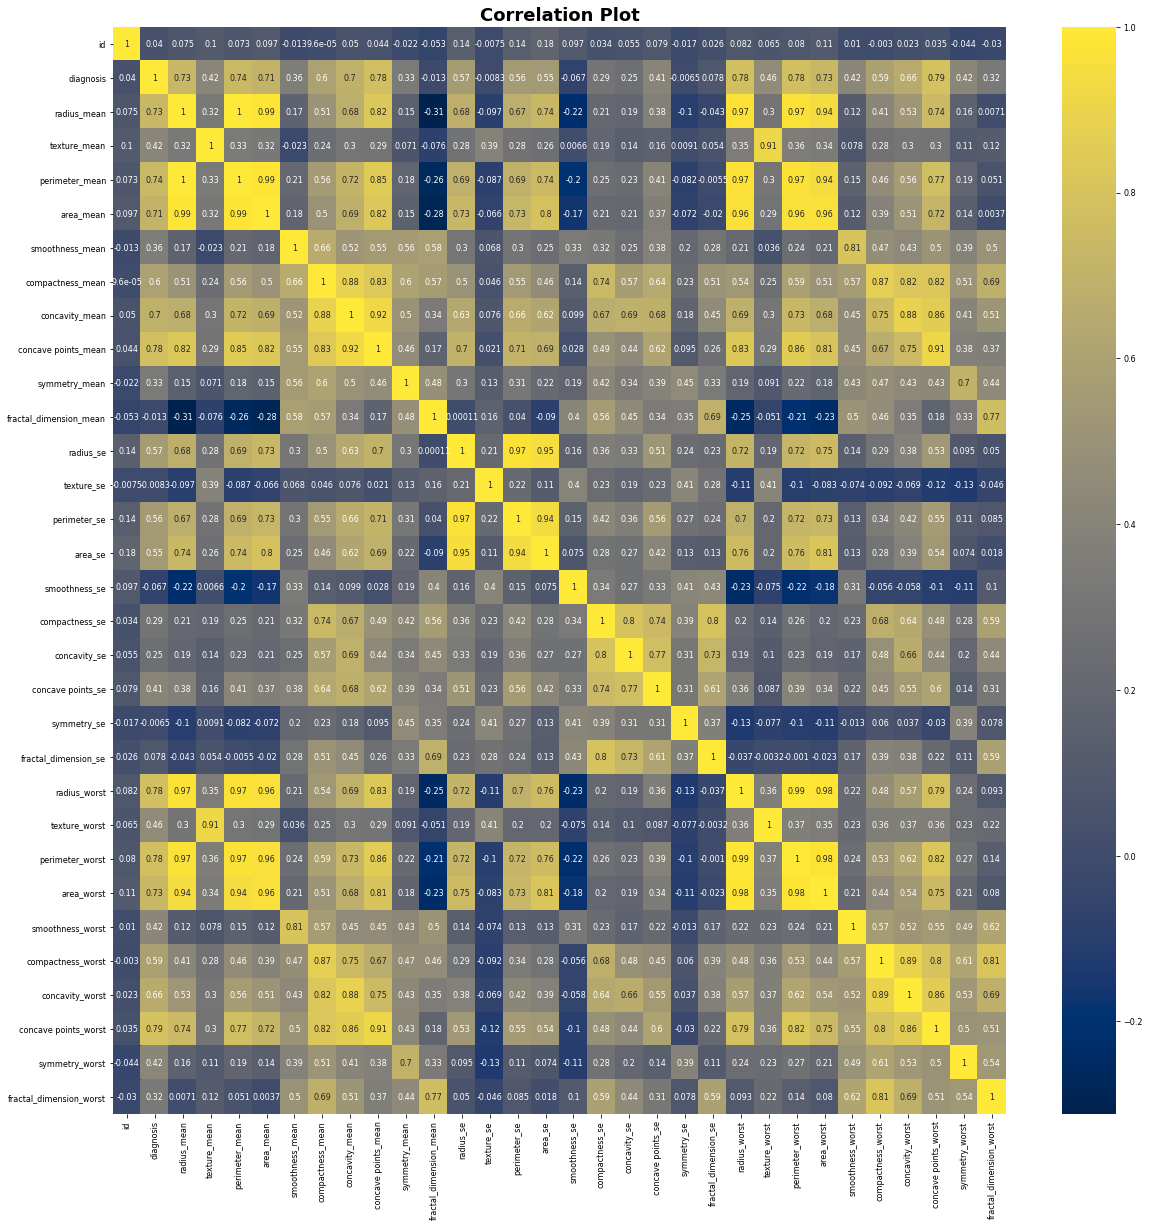

In [26]:
corr = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),  annot = True, cmap="cividis")
plt.title("Correlation Plot", fontweight = "bold", fontsize=18)

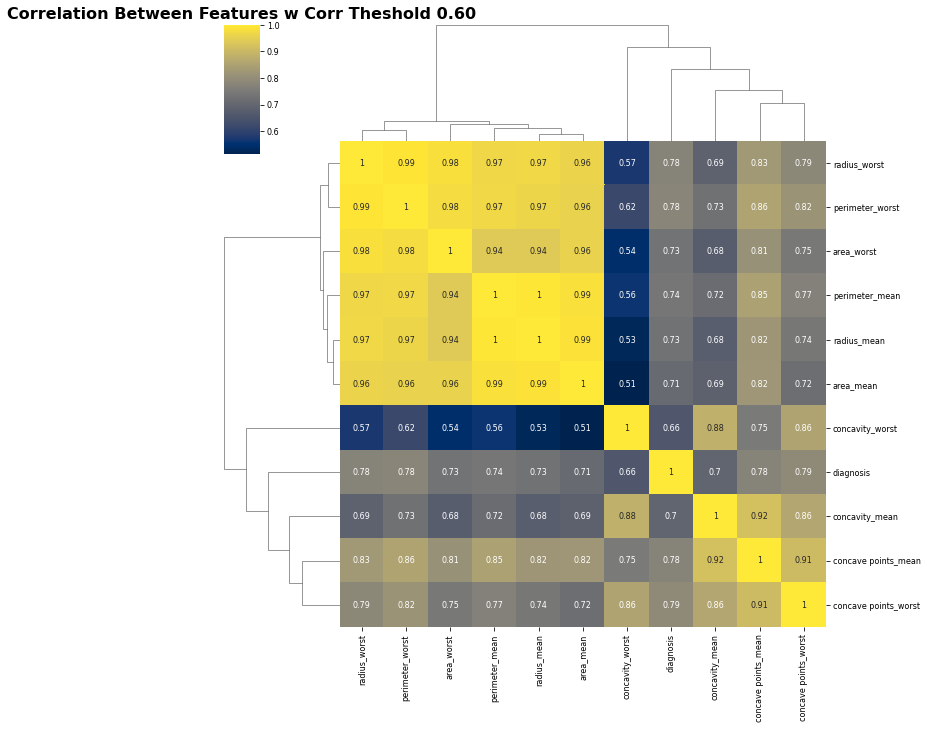

In [27]:
corr_matrix = data.corr()
threshold = 0.60 
filtre = np.abs(corr_matrix["diagnosis"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, cmap="cividis")
plt.title("Correlation Between Features w Corr Theshold 0.60", fontweight = "bold", fontsize=16)
plt.show()

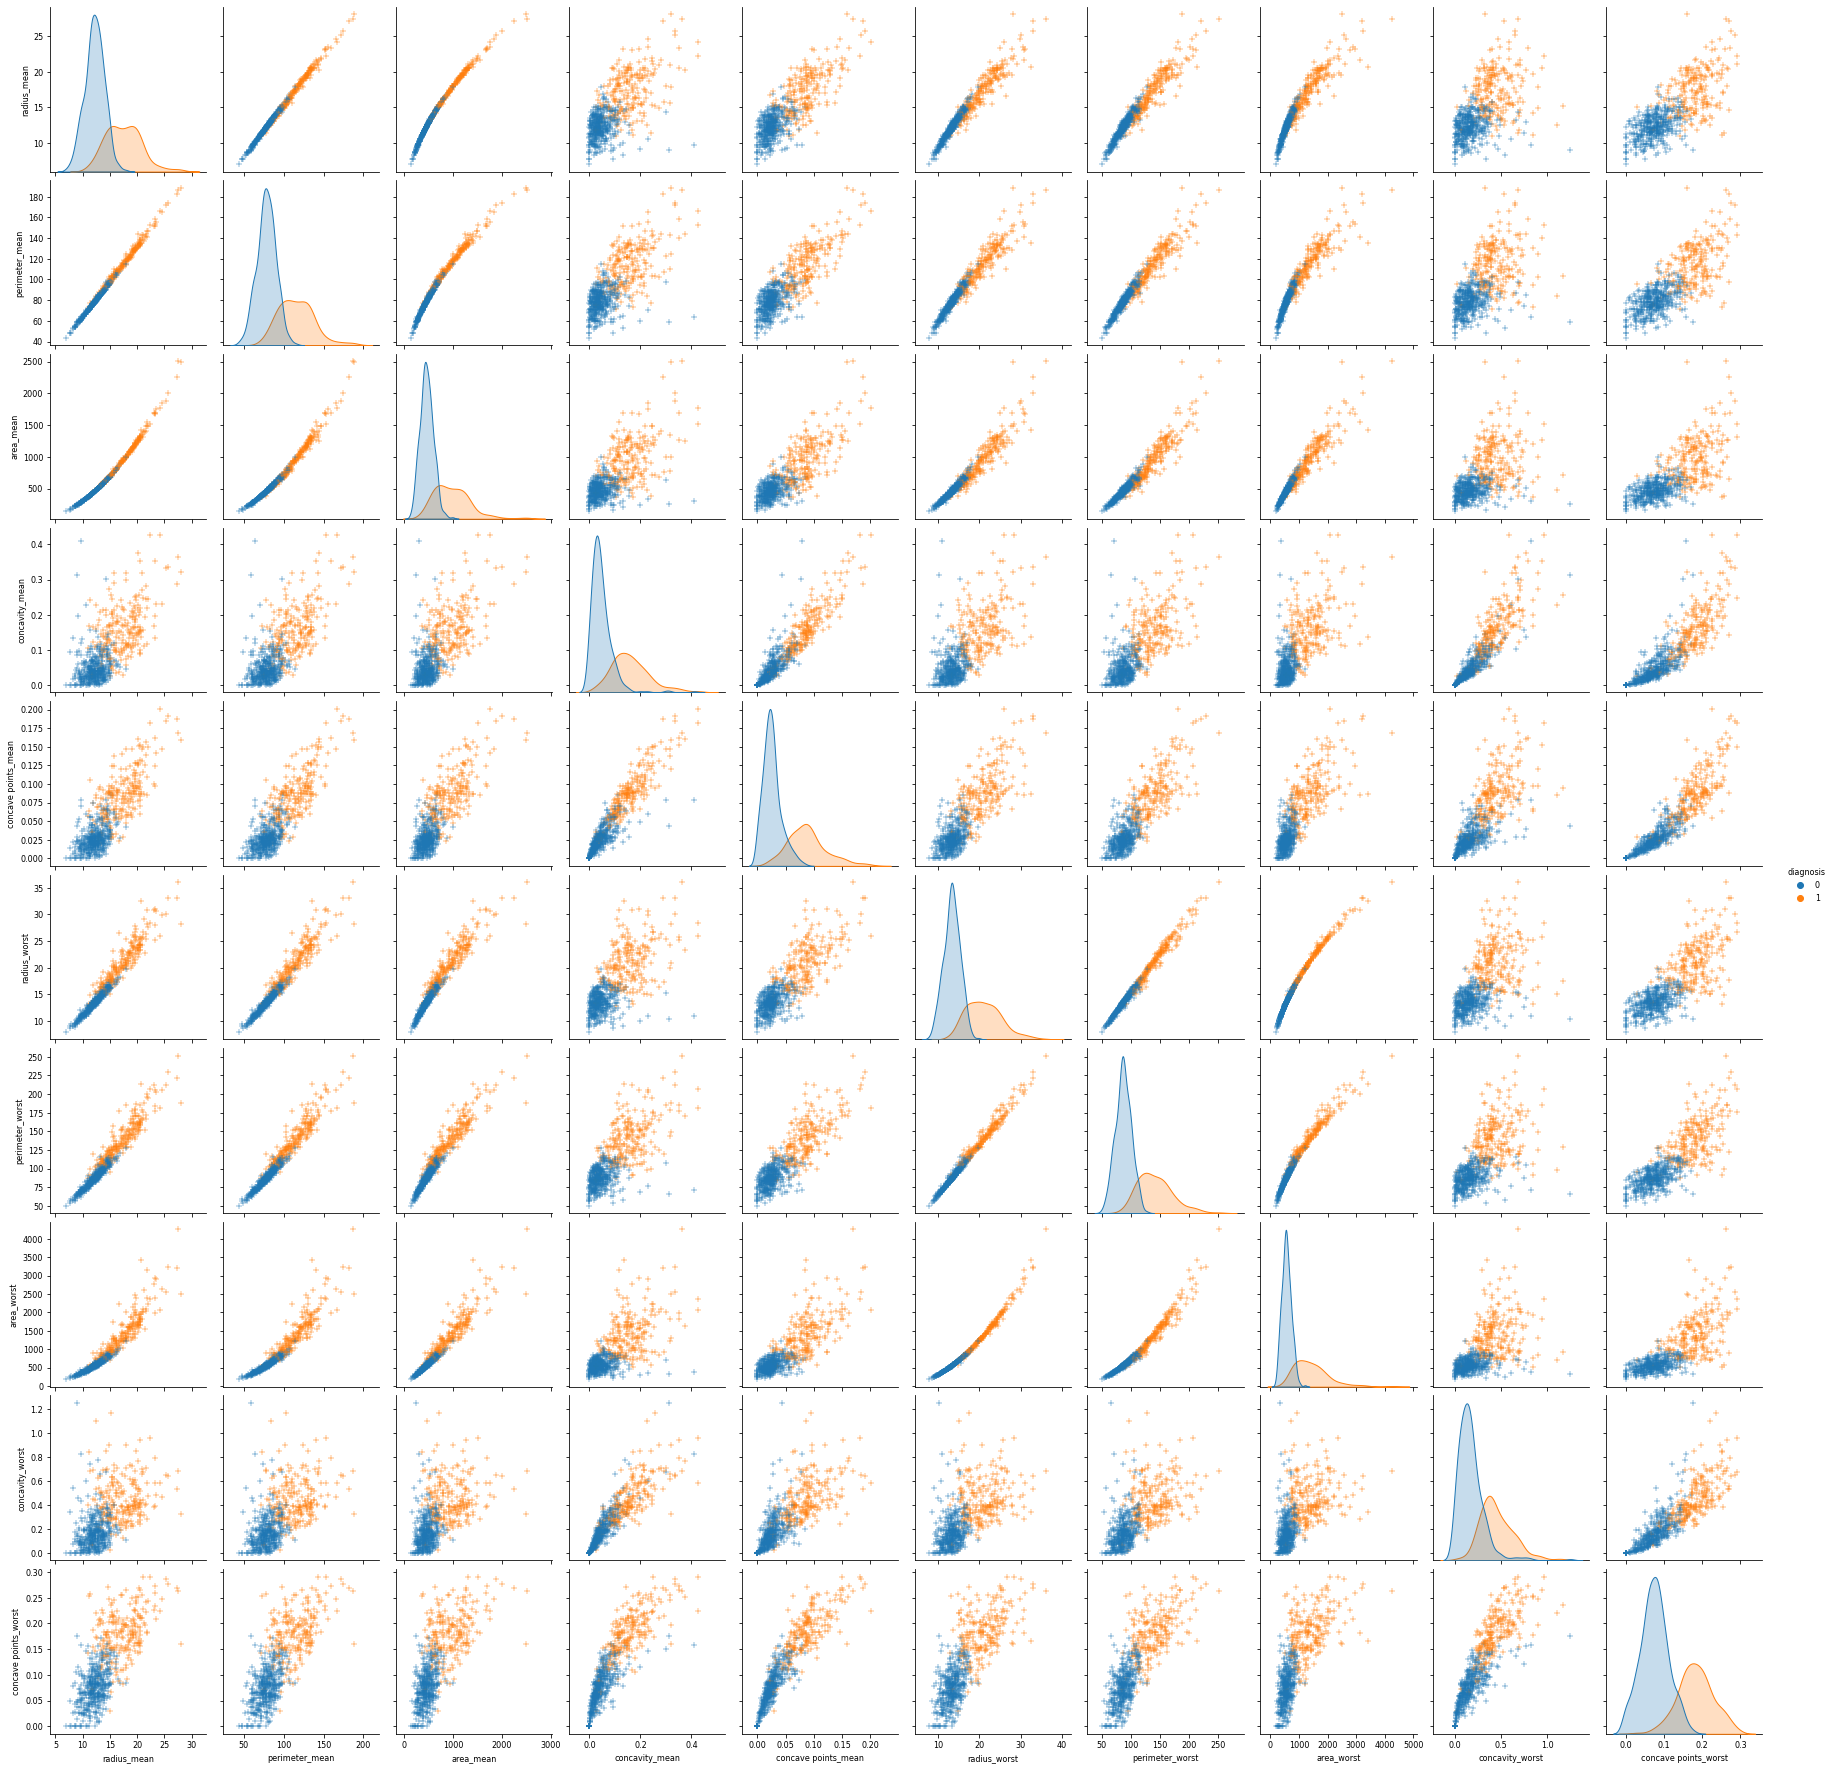

In [28]:
#Pair-wise comparison of features
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "diagnosis")
plt.show()

Based on the above analyses and observations, we can leverage correlated features and reasonably hypothesize that the cancer diagnosis depends on these.

### Creating test and training datasets

In [29]:
traindf, testdf = train_test_split(data, test_size = 0.3)

In [30]:
#Generic function for making a classification model and accessing the performance. 
# From AnalyticsVidhya tutorial
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  #kf = KFold(data.shape[0], n_folds=5)

  kf = KFold(n_splits = 5)

  error = []
  for train, test in kf.split(data[predictors]):
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

### Logistic Regression

In [31]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean']
outcome_var='diagnosis'
model=LogisticRegression()
classification_model(model,traindf,predictor_var,outcome_var)

Accuracy : 88.693%
Cross-Validation Score : 90.000%
Cross-Validation Score : 87.500%
Cross-Validation Score : 86.667%
Cross-Validation Score : 87.468%
Cross-Validation Score : 87.696%


In [32]:
predictor_var = ['radius_mean']
outcome_var='diagnosis'
model=LogisticRegression()
classification_model(model,traindf,predictor_var,outcome_var)

Accuracy : 85.930%
Cross-Validation Score : 88.750%
Cross-Validation Score : 85.625%
Cross-Validation Score : 85.833%
Cross-Validation Score : 86.843%
Cross-Validation Score : 86.437%


### Random Forest

In [33]:
# Use all the features of the nucleus
predictor_var = features_mean
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 95.477%
Cross-Validation Score : 92.500%
Cross-Validation Score : 92.500%
Cross-Validation Score : 92.500%
Cross-Validation Score : 92.160%
Cross-Validation Score : 91.196%


Using all the features improves the prediction accuracy and the cross-validation score is great.
An advantage with Random Forest is that it returns a feature importance matrix which can be used to select features. So lets select the top 5 features and use them as predictors.

In [34]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

concave points_mean       0.243368
area_mean                 0.161754
perimeter_mean            0.152216
concavity_mean            0.149191
radius_mean               0.128570
compactness_mean          0.059049
texture_mean              0.052183
smoothness_mean           0.022946
symmetry_mean             0.015631
fractal_dimension_mean    0.015093
dtype: float64


In [35]:
# Using top 5 features
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(model,traindf,predictor_var,outcome_var)

Accuracy : 93.719%
Cross-Validation Score : 92.500%
Cross-Validation Score : 92.500%
Cross-Validation Score : 92.083%
Cross-Validation Score : 92.164%
Cross-Validation Score : 91.199%


Using the top 5 features only changes the prediction accuracy a bit but I think we get a better result if we use all the predictors.
What happens if we use a single predictor as before? Just check.

In [36]:
predictor_var =  ['radius_mean']
model = RandomForestClassifier(n_estimators=100)
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 97.236%
Cross-Validation Score : 90.000%
Cross-Validation Score : 85.000%
Cross-Validation Score : 83.750%
Cross-Validation Score : 81.800%
Cross-Validation Score : 82.149%


This gives a better prediction accuracy too but the cross-validation is not great. Below I will assess other classifiers



### KNeighborsClassifier

In [37]:
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model = KNeighborsClassifier(n_neighbors = 2, weights ='uniform')
classification_model(model,traindf,predictor_var,outcome_var)

Accuracy : 90.704%
Cross-Validation Score : 82.500%
Cross-Validation Score : 83.125%
Cross-Validation Score : 83.750%
Cross-Validation Score : 82.433%
Cross-Validation Score : 83.161%


### SVC

In [38]:
model =SVC(kernel="rbf",random_state=15)
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 87.186%
Cross-Validation Score : 91.250%
Cross-Validation Score : 88.125%
Cross-Validation Score : 87.500%
Cross-Validation Score : 86.828%
Cross-Validation Score : 86.677%


### DecisionTreeClassifier

In [39]:
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model=DecisionTreeClassifier(random_state=10)
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 87.500%
Cross-Validation Score : 89.375%
Cross-Validation Score : 90.417%
Cross-Validation Score : 89.964%
Cross-Validation Score : 89.693%


### RandomForestClassifier

In [40]:
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
#model=RandomForestClassifier(n_estimators=60, random_state=0)
model=RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 93.719%
Cross-Validation Score : 91.250%
Cross-Validation Score : 90.625%
Cross-Validation Score : 90.417%
Cross-Validation Score : 90.914%
Cross-Validation Score : 90.453%


### GradientBoostingClassifier

In [41]:
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model=GradientBoostingClassifier(random_state=20)
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 88.750%
Cross-Validation Score : 91.250%
Cross-Validation Score : 91.250%
Cross-Validation Score : 91.222%
Cross-Validation Score : 90.699%


### AdaBoostClassifier

In [42]:
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model=AdaBoostClassifier()
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 97.487%
Cross-Validation Score : 87.500%
Cross-Validation Score : 89.375%
Cross-Validation Score : 89.583%
Cross-Validation Score : 89.339%
Cross-Validation Score : 89.193%


### XGBClassifier

In [43]:
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model=xgb.XGBClassifier(random_state=0,booster="gbtree", eval_metric="logloss")
classification_model(model, traindf,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 87.500%
Cross-Validation Score : 89.375%
Cross-Validation Score : 90.417%
Cross-Validation Score : 90.281%
Cross-Validation Score : 89.946%


## Using on the test data set

In [44]:
# Use all the features of the nucleus
predictor_var = features_mean
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, testdf,predictor_var,outcome_var)

Accuracy : 98.830%
Cross-Validation Score : 94.286%
Cross-Validation Score : 94.202%
Cross-Validation Score : 95.154%
Cross-Validation Score : 92.689%
Cross-Validation Score : 93.563%


### Model Accuracies

In [45]:
models=['Logistic Regression ', 'Random Forest', 'KNeighbors','SVC', 'DecisionTree', 'GradientBoosting','AdaBoost', 'XGB']

plot = go.Bar(x=models, y=[89.698, 95.477, 90.201,88.945,100.000, 100.000, 98.492,100.000],
               opacity = 0.5, marker=dict(color = 'steelblue',line=dict(color='gray',width=0.5))) 

layout = dict(title =  'Model Accuracies', plot_bgcolor = "white")
                    
fig = dict(data = [plot], layout=layout)
py.iplot(fig)
